In [17]:
# Dependencies and Setup
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy.stats import linregress
import scipy.stats as st
from config import gkey
import gmaps


gmaps.configure(api_key=gkey)

# Read the data from csv's created in the data cleanup process
zips_df = pd.read_csv(r"resources/zip_code_data_cleaned.csv")
unemployment_df = pd.read_csv(r"resources/KS_MO_Unemployment_Data_Cleaned.csv")
census_data_df = pd.read_csv(r"resources/census_data.csv")
ppp_data_df = pd.read_csv(r"resources/PPP Data Combined.csv")

C:\Users\rdgg3\.conda\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


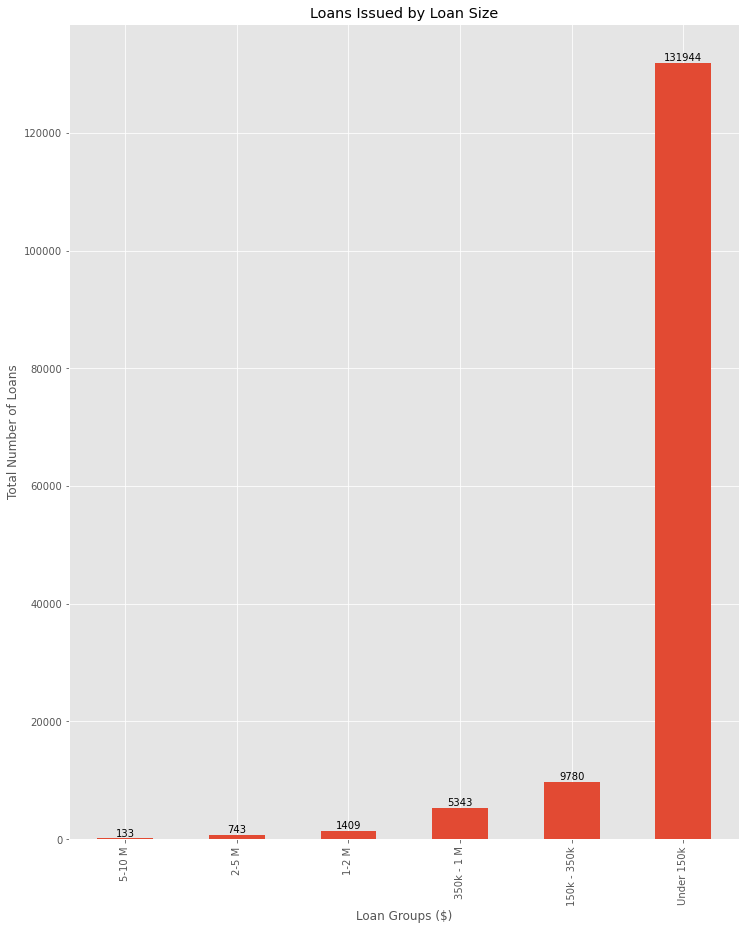

In [28]:
ppp_loan_count_df = ppp_data_df.groupby(ppp_data_df['Loan Code']).count()
plt.style.use('ggplot')

loan_amount = ppp_loan_count_df['Zip']
x = ['5-10 M', '2-5 M', '1-2 M', '350k - 1 M', '150k - 350k', 'Under 150k']
x_labels = ppp_loan_count_df['Zip']

plt.figure(figsize=(12, 15))
ax = loan_amount.plot(kind='bar')
ax.set_title('Loans Issued by Loan Size')
ax.set_xlabel('Loan Groups ($)')
ax.set_ylabel('Total Number of Loans')
ax.set_xticklabels(x)

# code below: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
rects = ax.patches

for rect, loan_amount in zip(rects, loan_amount):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, loan_amount,
            ha='center', va='bottom')
#plt.savefig('Loans_Issued.png')
plt.show()

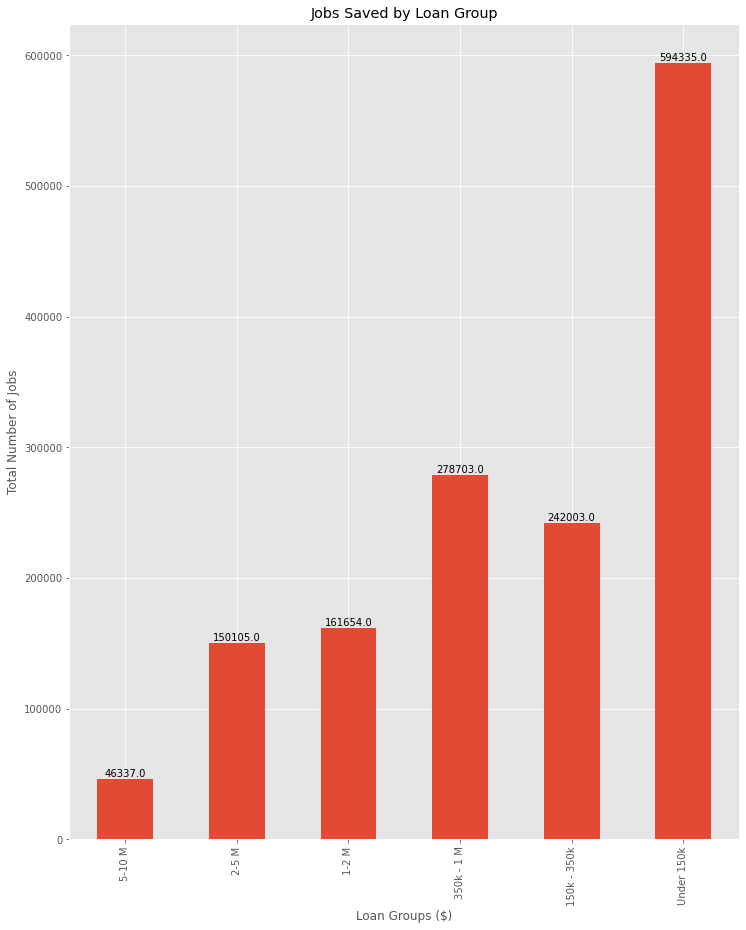

In [29]:
ppp_job_creation_df = ppp_data_df.groupby(ppp_data_df['Loan Code']).sum()
jobs_created = ppp_job_creation_df['JobsReported']
plt.style.use('ggplot')


x_labels = ['5-10 M', '2-5 M', '1-2 M', '350k - 1 M', '150k - 350k', 'Under 150k']

plt.figure(figsize=(12, 15))
ax = jobs_created.plot(kind='bar')
ax.set_title('Jobs Saved by Loan Group')
ax.set_xlabel('Loan Groups ($)')
ax.set_ylabel('Total Number of Jobs')
ax.set_xticklabels(x)

rects = ax.patches

# code below: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
for rect, jobs_created in zip(rects, jobs_created):                
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, jobs_created,
            ha='center', va='bottom')
plt.savefig('jobs_reported.png')
plt.show()

Were jobs saved in KS and MO?
==========================
To find out whether the PPP accomplished it's goal of keeping people employed, we plotted the amount of loans issued against the number of jobs saved.

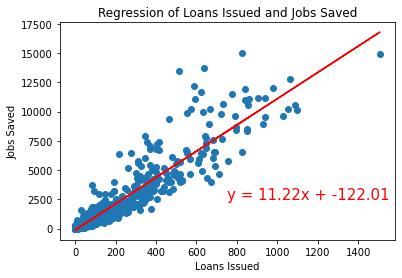

In [6]:
# Combine the data into a single datasets
ppp_data_clean_df = ppp_data_df[["LoanRange","State","Zip","JobsReported","DateApproved"]]
ppp_data_clean_df = ppp_data_clean_df.rename(columns={"Zip":"Zipcode"})

# Combine PPP data with census data
ppp_census_df = pd.merge(ppp_data_clean_df, census_data_df, on="Zipcode")
ppp_census_df

# Build regression outline
regression_df = pd.DataFrame({
    "Loans Issued": ppp_census_df.groupby("Zipcode").count()["State"],
    "Jobs Saved": ppp_data_clean_df.groupby("Zipcode").sum()["JobsReported"]
}).dropna()

x_values = regression_df["Loans Issued"]
y_values = regression_df["Jobs Saved"]

def plot_linear_regression(x_values, y_values, title, x_label, y_label, text_coordinates):
    # Run regression on hemisphere weather data.
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
    # Calculate the regression line "y values" from the slope and intercept.
    regress_values = x_values * slope + intercept
    # Get the equation of the line.
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Create a scatter plot and plot the regression line.
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r")
    # Annotate the text for the line equation.
    plt.annotate(line_eq, text_coordinates, fontsize=15, color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

plot_linear_regression(x_values, y_values, "Regression of Loans Issued and Jobs Saved", "Loans Issued", "Jobs Saved", (750,2500))

Findings
-------------
There is a positive correlation between these two items, leading us to believe that the PPP did meet it's goal. We have some reservations, however. First, the number of loans issued is simply an aggregate that does not take into consideration loan amounts. Second, jobs saved is a self-reported number by the businesses who applied for the loans, leading to possible skew in actual unemployment numbers. Despite this, it is in a business' best interest to keep employees after receiving the loan due to the stipulation that converts the loan into a grant if employees are retained. We keep digging into the data to gather more insights into demographics below.

Demographic Analysis
===================

## Impact vs. Poverty
We thought it might be worth exploring the relationship between the poverty rate and the number of jobs added to find out if the PPP loans were distributed to the communities that needed it the most. Our analysis is as follows:
- Compare the poverty rate (a percentage) against the number of jobs added per 100 people in the county
- Run regression to test correlation
- Split the data by state and rerun regression analysis to find changes

In [9]:
# Add some derived rows to do some quick analytics on
grouped_df = pd.read_csv(r"resources/grouped_df.csv")
grouped_df["Poverty Rate"] = round(grouped_df["Poverty Count"] / grouped_df["Population"] * 100,2)
grouped_df["Job Impact"] = round(grouped_df["JobsReported"] / grouped_df["Population"] * 100,2)
grouped_df["Percent Hispanic"] = round(grouped_df["Hispanic or Latino"] / grouped_df["Population"] * 100,2)
grouped_df["Percent Non-White"] = round(100 - grouped_df["White Alone"] / grouped_df["Population"] * 100,2)
grouped_df

,State,County,Population,Poverty Count,Hispanic or Latino,White Alone,JobsReported,Poverty Rate,Job Impact,Percent Hispanic,Percent Non-White
0,KS,Allen,13064.0,2141.0,395.0,12179.0,195,16.39,1.49,3.02,6.77
1,KS,Anderson,8210.0,1040.0,14.0,7855.0,116,12.67,1.41,0.17,4.32
2,KS,Atchison,16548.0,2567.0,449.0,15049.0,240,15.51,1.45,2.71,9.06
3,KS,Barber,4407.0,488.0,96.0,4253.0,167,11.07,3.79,2.18,3.49
4,KS,Barton,27808.0,3774.0,3777.0,25561.0,782,13.57,2.81,13.58,8.08
...,...,...,...,...,...,...,...,...,...,...,...
215,MO,Washington,22909.0,5372.0,191.0,21857.0,108,23.45,0.47,0.83,4.59
216,MO,Wayne,13956.0,2881.0,145.0,13584.0,156,20.64,1.12,1.04,2.67
217,MO,Webster,31736.0,5918.0,605.0,30452.0,431,18.65,1.36,1.91,4.05
218,MO,Worth,2206.0,273.0,23.0,2185.0,30,12.38,1.36,1.04,0.95


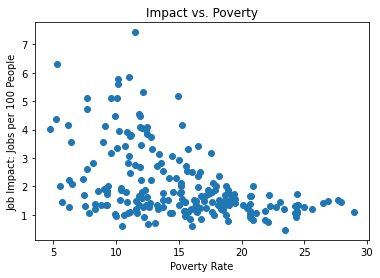

In [10]:
# Compare the poverty rate (a percentage) against the number of jobs added per 100 people in the county
# This shows is striking trend
plt.scatter(x=grouped_df["Poverty Rate"],y=grouped_df["Job Impact"])
plt.xlabel("Poverty Rate")
plt.ylabel("Job Impact: Jobs per 100 People")
plt.title("Impact vs. Poverty")
plt.show()

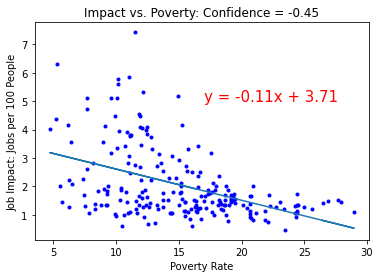

In [11]:
# Rerun the above scatter but with a trend line. The confidence interval is not overwhelming, but the trend is notable.
# The poorer the county, the less help was received from PPP loans
(slope, intercept, rvalue, pvalue, stderr) = linregress(grouped_df["Poverty Rate"],grouped_df["Job Impact"])
regress_values = grouped_df["Poverty Rate"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(grouped_df["Poverty Rate"],grouped_df["Job Impact"],marker=".",color="blue")
plt.plot(grouped_df["Poverty Rate"],regress_values)
plt.annotate(line_eq,(17,5),fontsize=15,color="red")
plt.xlabel("Poverty Rate")
plt.ylabel("Job Impact: Jobs per 100 People")
plt.title("Impact vs. Poverty: Confidence = " + 
          str(round(st.pearsonr(grouped_df["Poverty Rate"],grouped_df["Job Impact"])[0],2)))
plt.show()

In [12]:
# Split the data by state
kansas_df = grouped_df.query("State == 'KS'")
missouri_df = grouped_df.query("State == 'MO'")

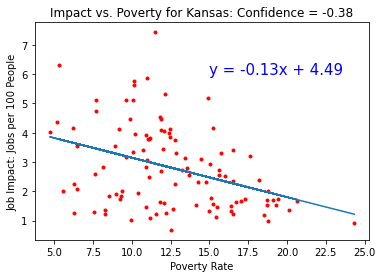

In [13]:
# Run the regression for Kansas. The trend line is still pronounced
(slope, intercept, rvalue, pvalue, stderr) = linregress(kansas_df["Poverty Rate"],kansas_df["Job Impact"])
regress_values = kansas_df["Poverty Rate"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(kansas_df["Poverty Rate"],kansas_df["Job Impact"],marker=".",color="red")
plt.plot(kansas_df["Poverty Rate"],regress_values)
plt.annotate(line_eq,(15,6),fontsize=15,color="blue")
plt.xlabel("Poverty Rate")
plt.ylabel("Job Impact: Jobs per 100 People")
plt.title("Impact vs. Poverty for Kansas: Confidence = " + 
          str(round(st.pearsonr(kansas_df["Poverty Rate"],kansas_df["Job Impact"])[0],2)))
plt.show()

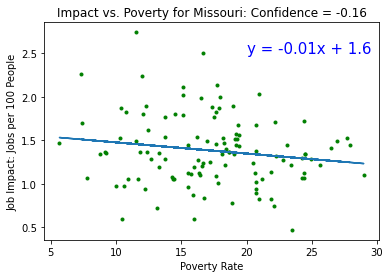

In [14]:
# Run the trend line for Missouri. Remarkably, there is essentially no correlation.
(slope, intercept, rvalue, pvalue, stderr) = linregress(missouri_df["Poverty Rate"],missouri_df["Job Impact"])
regress_values = missouri_df["Poverty Rate"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(missouri_df["Poverty Rate"],missouri_df["Job Impact"],marker=".",color="green")
plt.plot(missouri_df["Poverty Rate"],regress_values)
plt.annotate(line_eq,(20,2.5),fontsize=15,color="blue")
plt.xlabel("Poverty Rate")
plt.ylabel("Job Impact: Jobs per 100 People")
plt.title("Impact vs. Poverty for Missouri: Confidence = " + 
          str(round(st.pearsonr(missouri_df["Poverty Rate"],missouri_df["Job Impact"])[0],2)))
plt.show()

Findings
-------------
- Recognize that both KS and MO had roughly the same amount of loans issued (105k vs 115k respectively).
- MO had fewer loans per capita than KS, with loans distributed relatively evenly per county based on income levels.
- KS had more loans per capita than MO, but the loans were not as evenly distributed with more loans going to wealthier counties.

Challenges and Hurldes
====================
